# 시카고 범죄율 예측하기

- 시카고 경찰서에서 2001년부터 2017년까지 보고된 범죄를 요약하였다. 
- 데이터 열: 
    - ID: 고유식별자
    - Case Number: 시카고경찰서 RD 넘버
    - Date: 사건이 일어난 날
    - Block: 사건이 일어난 주소
    - IUCR: 일종의 일리노이주의 고유 식별자
    - Primary Type: IUCR code 즉, 범죄 종류
    - Description: 코드의 부차적 설명
    - Location Description: 발생 장소에 대한 설명
    - Arrest: 체포의 유무
    - Domestic: 일리노이주 가정폭력 법에서 정의한 가정폭력과 관련된 사건
    - Beat: 사건이 발생한 지리상의 지도 
    - District: 사건이 발생한 구역
    - Ward: 사건이 발생한 시의회 구역 
    - Community Area: 사건이 발생한 공동체지역 
    - FBI Code: FBI가 사용하는 범죄 분류 코드 
    - X Coordinate: X좌표 
    - Y Coordinate: Y좌표
    - Year: 발생년도
    - Updated On: 기록이 마지막으로 갱신된 시간과 날짜
    - Latitude: 위도
    - Longitude: 경도
    - Location: 장소
- 출처: https://www.kaggle.com/currie32/crimes-in-chicago




- 날짜 별로 발생한 범죄의 수를 보고 페이스북 prophet을 이용하여 시계열 데이터를 예측한다.

In [ ]:
# pip install fbprophet 한다

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet
import warnings
warnings.filterwarnings(action='ignore')


ModuleNotFoundError: No module named 'fbprophet'

In [2]:
# 누락되거나 손상된 데이터 제외
df_1 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
df_2 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
df_3 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

C:\Users\komsco\AppData\Local\Temp\ipykernel_14428\2922019384.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_1 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
b'Skipping line 533719: expected 23 fields, saw 24\n'
C:\Users\komsco\AppData\Local\Temp\ipykernel_14428\2922019384.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_2 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
b'Skipping line 1149094: expected 23 fields, saw 41\n'
C:\Users\komsco\AppData\Local\Temp\ipykernel_14428\2922019384.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_3 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)


In [3]:
df = pd.concat([df_1, df_2, df_3], ignore_index=False, axis=0)

# 데이터 시각화

In [4]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


<AxesSubplot:>

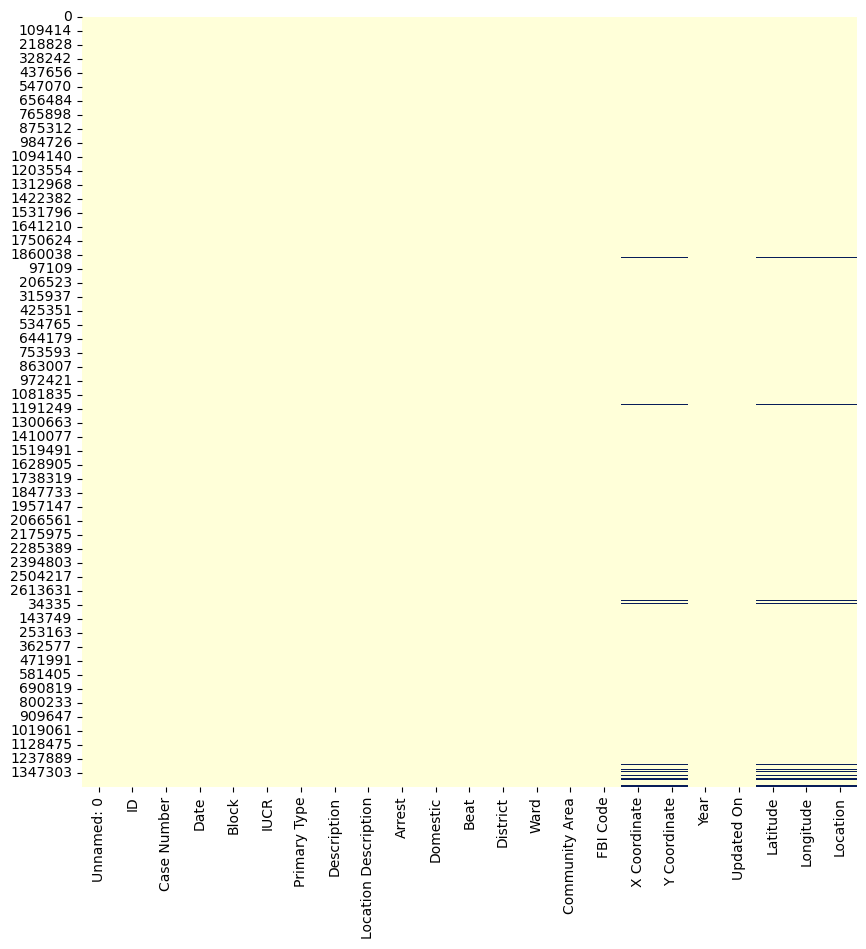

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(df.isnull(), cbar = False, cmap = 'YlGnBu')

칠해져 있는 부분들이 누락된 데이터 세트다. 이 부분들을 제외시키도록 한다.

In [6]:
df.drop(['Unnamed: 0', 'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'], inplace=True, axis=1)

prophet에 알맞게 분석할 수 있도록 Date열을 재배열한다.

In [7]:
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')
df.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False


범죄 종류 리스트 중 상위 15개를 추출한다.

<AxesSubplot:xlabel='count', ylabel='Primary Type'>

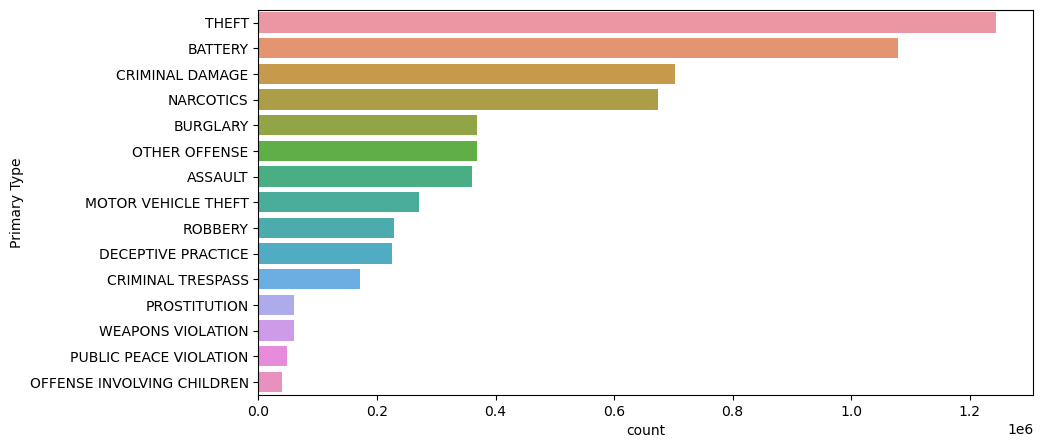

In [12]:
order_data = df['Primary Type'].value_counts().iloc[:15].index
plt.figure(figsize=(10, 5))
sns.countplot(y='Primary Type', data = df, order= order_data)

도둑질과 구타가 압도적으로 높을 것을 확인할 수 있다.

범죄 발생 장소 리스트 추출

<AxesSubplot:xlabel='count', ylabel='Location Description'>

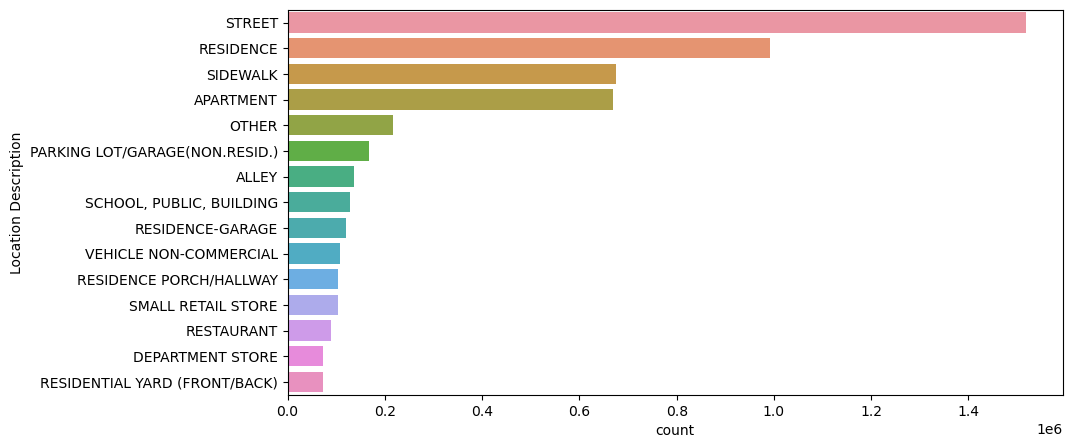

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(y= 'Location Description', data = df, order = df['Location Description'].value_counts().iloc[:15].index)

길, 주택, 인도, 아파트 순으로 발생하는 것을 볼 수 있다.

해마다 범죄가 발생한 건수를 표현해보자.

Text(0, 0.5, 'Number of Crimes')

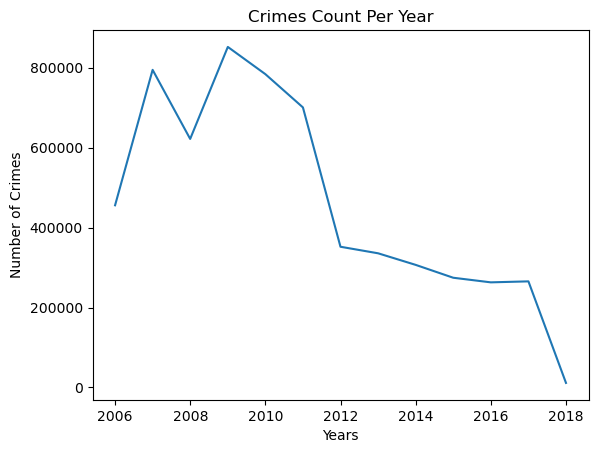

In [15]:
df.index = pd.DatetimeIndex(df.Date)
plt.plot(df.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

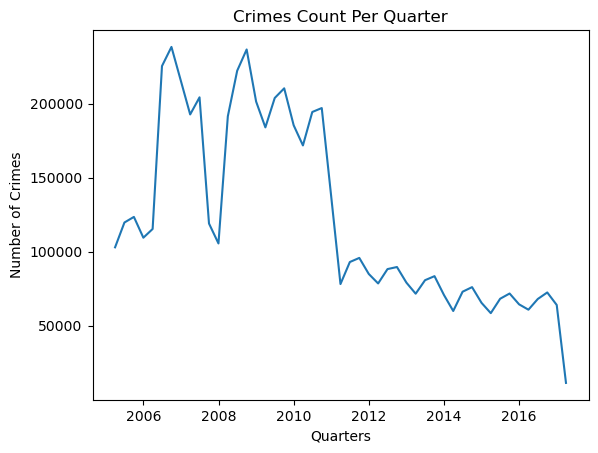

In [20]:
plt.plot(df.resample('Q').size())
plt.title('Crimes Count Per Quarter')
plt.xlabel('Quarters')
plt.ylabel('Number of Crimes')

# prophet을 이용하여 데이터 예측하기

In [22]:
# 월 기준으로 인덱스화 시키기.
prophet = df.resample('M').size().reset_index()
prophet.columns = ['Date', 'Crime Count']
prophet_df = pd.DataFrame(prophet)

In [ ]:
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=365) # 365일 뒤까지 예측
forecast = m.predict(future)

forecast.head()

In [ ]:
figure = m.plot(forecast, xlabel='Date', ylabel='Crime Rate')

- 검정점: 데이터 포인트
- 선: 추세선

계절에 따른 범죄율 예측

In [ ]:
figure3 = m.plot_components(forecast)